In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


d:\anaconda\envs\OPENAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
words = open("names.txt" , 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s , i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [6]:
#dataset
block_size = 3  #context length
X , Y = [] , []

for w in words[:5]:
    print(w)

    context = [0] * block_size
    # print(context)
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context) , '--->' , itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .
isabella
... ---> i
..i ---> s
.is ---> a
isa ---> b
sab ---> e
abe ---> l
bel ---> l
ell ---> a
lla ---> .
sophia
... ---> s
..s ---> o
.so ---> p
sop ---> h
oph ---> i
phi ---> a
hia ---> .


In [7]:
X.shape , X.dtype , Y.shape , Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [8]:
C = torch.randn((27 , 2))          #Lookup table
C

tensor([[-6.0961e-04, -1.1714e+00],
        [-5.2460e-01, -8.3531e-01],
        [-9.2176e-01,  1.0473e+00],
        [-8.5712e-01, -1.6196e+00],
        [-9.1910e-01,  1.8196e+00],
        [-4.4415e-01, -5.0334e-01],
        [-1.7544e+00,  6.5315e-01],
        [ 2.0224e-01, -9.7768e-01],
        [ 8.7359e-02, -1.2943e+00],
        [ 3.3231e-01, -1.7259e-01],
        [ 1.1560e-01,  7.2818e-01],
        [-1.3281e+00, -6.8505e-01],
        [-6.7501e-01,  1.2782e+00],
        [-5.4191e-01,  9.6349e-02],
        [ 7.4797e-01,  8.1311e-01],
        [ 2.7716e-01,  4.6552e-01],
        [ 1.0445e+00,  1.8726e+00],
        [ 5.8755e-01,  6.4407e-01],
        [-3.4831e-02,  1.5529e+00],
        [-4.3322e-01,  4.2811e-01],
        [-1.5167e+00, -8.9239e-01],
        [ 2.2171e+00,  3.1371e-01],
        [ 5.5331e-01,  2.5524e-01],
        [ 4.6769e-01,  1.6033e+00],
        [ 1.0452e-01, -6.7837e-01],
        [-3.0877e-01, -7.7499e-01],
        [-2.9567e-01,  2.1000e+00]])

In [9]:
F.one_hot(torch.tensor(5) , num_classes=27).float() @ C  #将字母映射到2维空间   =C[5]

tensor([-0.4441, -0.5033])

In [10]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [11]:
W1 = torch.randn((6 , 100))
b1 = torch.randn(100)

In [12]:
# 结果相同
torch.cat(torch.unbind(emb , 1) , 1).shape

h = torch.tanh(emb.view(-1 , 6) @ W1 + b1)
h

tensor([[-0.8308, -0.9901, -0.9838,  ...,  0.9929,  0.7526,  0.9844],
        [-0.9622, -0.9752, -0.9721,  ...,  0.9961,  0.6140,  0.8738],
        [-0.9717, -0.4645, -0.7286,  ...,  0.9841,  0.5144, -0.0694],
        ...,
        [ 0.9800, -0.9936,  0.0482,  ...,  0.5256,  0.9989,  0.4712],
        [ 0.1190, -0.9789,  0.3241,  ...,  0.9999,  0.9991,  0.8790],
        [-0.7446, -0.9883, -0.9333,  ...,  0.9637,  0.7645,  0.8185]])

In [13]:
# Temp = torch.tensor(([[[1 , 2 , 3],[4 , 5 , 6]],[[7 , 8 , 9],[10 , 11 , 12]]]))
# print(Temp)
# print(torch.unbind(Temp , 1))
# print(torch.cat(torch.unbind(Temp , 1) , 1))

In [14]:
W2 = torch.randn((100 , 27))
b2 = torch.randn(27)

logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1 , keepdim=True)


In [15]:
loss = -prob[torch.arange(X.shape[0]) , Y].log().mean()


In [18]:
# Summary
import random
words = open('names.txt' , 'r').read().splitlines()

chars = sorted(list(set(''.join(words))))
stoi = {s : i + 1 for i , s in enumerate(chars)}
stoi['.'] = 0
itos = {i : s for s , i in stoi.items()}

def build_dataset(words):
    block_size = 3
    X , Y = [] , []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context) , '--->' , itos[ix])
            context = context[1 :] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape , Y.shape) 
    return X , Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr , Ytr = build_dataset(words[:n1])     #train data
Xdev , Ydev = build_dataset(words[n1:n2]) #dev data
Xte , Yte = build_dataset(words[n2:])     #test data



torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [24]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27 , 10) , generator = g)
W1 = torch.randn((30 , 300) , generator = g)
b1 = torch.randn(300 , generator = g)
W2 = torch.randn((300 , 27) , generator = g)
b2 = torch.randn(27 , generator=g)

parameters = [C , W1 , b1 , W2 , b2]
total_parameters = sum(p.nelement() for p in parameters)

for p in parameters:
    p.requires_grad = True

In [31]:
##如何调整学习率lr，记录不同学习率的loss，找到合理lr的上下界并在上下界中生成不同的学习率
##根据不同学习率在loss上的表现选择最佳学习率区间
# lre = torch.linspace(-3 , 0 , 1000)
# lrs = 10 ** lre           #lr  =  0.001 --- 1

lri = []
lossi = []
stepi = []

for i in range(30000):
    #mini batch
    ix = torch.randint(0 , Xtr.shape[0] , (32 , ))

    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1 , 6) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1 , keepdims=True)
    # loss = -prob[torch.arange(32) , Y].log().mean()
    loss = F.cross_entropy(logits , Ytr[ix])
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    #可以随着训练轮数的增加进行学习率衰减
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    #track stats
    # lri.append(lre[i])
    lossi.append(loss.item())
    stepi.append(i)
        
print(f'loss : {loss.item()}')



loss : 1.9347702264785767


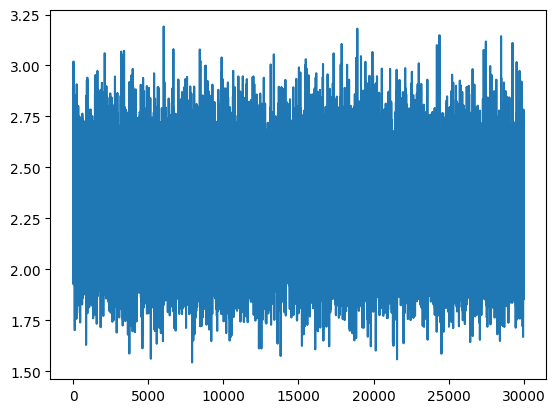

In [33]:
plt.plot(stepi , lossi)

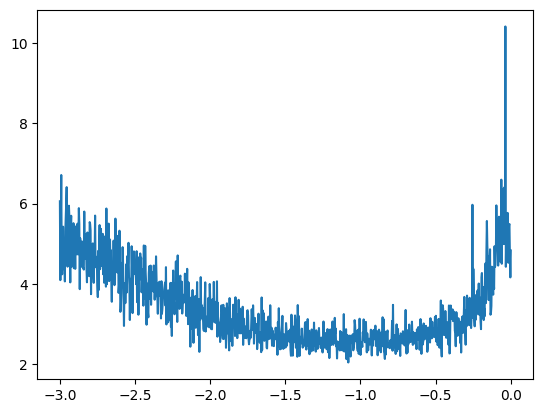

In [75]:
plt.plot(lri , lossi)
#如图所示lre = [-1 , -0.5]效果较好


In [32]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1 , 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits , Ydev)
print(f'total loss : {loss.item()}')

total loss : 2.273022413253784


In [34]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor(context)]
        h = torch.tanh(emb.view(1 , -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits , dim=1)
        ix = torch.multinomial(probs , num_samples=1 , generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mrix.
thty.
salan.
kejrahnen.
delly.
cilaeni.
ner.
kia.
ceriia.
kaleig.
hham.
joi.
deshan.
sroilea.
jadia.
wazero.
dearyxi.
